In [1]:
using ChaosTools
using DynamicalSystems
using PyPlot
using OrdinaryDiffEq, LinearAlgebra, ForwardDiff, PyPlot
using Distributions

In [18]:
PyPlot.pygui(false)

false

In [2]:

x = rand(Truncated(Normal(0, 1.), -1., 1.), 100)
x=x.-8
y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
grid=Iterators.product(x,y)
grid=collect.(grid)
println(grid[1])
println(grid[1][1])
#pre(grid[1][1],grid[1][2],m[1],m[2],a,b,Hinicial)

[-7.866904801052444, -0.4270921971915876]
-7.866904801052444


  0.250740 seconds (1.16 M allocations: 53.946 MiB, 6.08% gc time)
  0.000043 seconds (7 allocations: 78.406 KiB)
  0.471519 seconds (1.15 M allocations: 58.728 MiB, 2.79% gc time)


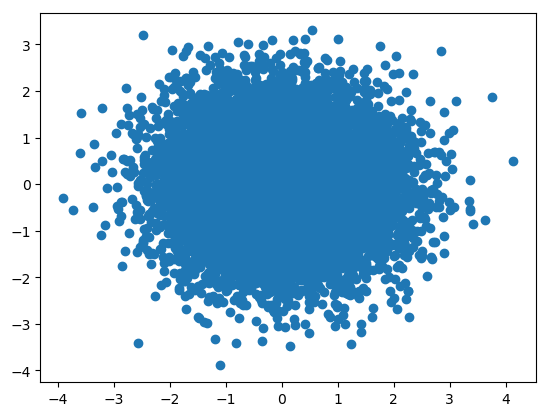

  0.158596 seconds (319.60 k allocations: 16.064 MiB)


10000-element Array{Float64,1}:
 -0.5395290784302094 
 -0.5197976280394084 
 -0.4247488996234404 
 -0.5443123417854692 
 -0.5537817663919989 
 -0.44568945287325756
 -0.287854522255064  
 -0.3796079267357887 
 -0.5510641435587704 
 -0.40094047114064324
 -0.59313658330207   
 -0.5922930839297915 
 -0.547344343119895  
  ⋮                  
 -0.6005908147439606 
 -0.6132525341118371 
 -0.48087103826039346
 -0.6048139182467266 
 -0.45024653145722826
 -0.449303013728834  
 -0.5243500605877449 
 -0.3714821032538173 
 -0.428307403347611  
 -0.3112075367300051 
 -0.6164966535717186 
 -0.49387772050535167

In [2]:
arraysize=10000
@time u1 = rand(arraysize)
@time u2 = rand(arraysize)
@time z0 = map.(sqrt,-2* map.(log,u1)) .*map.(cos,2. *pi*u2)
@time z1 = map.(sqrt,-2* map.(log,u1)) .*map.(sin,2. *pi*u2)
scatter(z0,z1)

xz0=z0*0.15
pz1=z1*0.1
Xz0=z0 .-10.
Pz1=z1*0.1 .-0.5

#x=x.-8
#y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
#grid=Iterators.product(x,y)
#grid=collect.(grid)
#println(grid[1])
#println(grid[1][1])

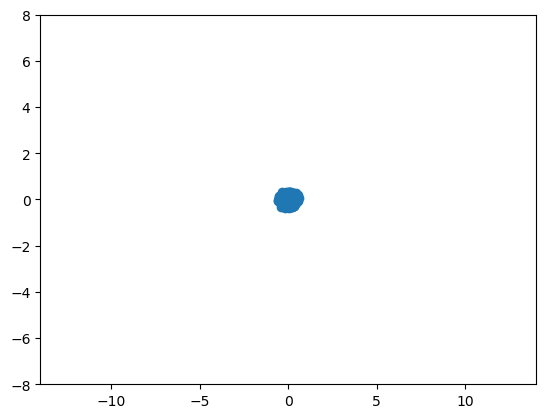

(-14, 14)

In [3]:
scatter(xz0,pz1)
ylim(-8,8)
xlim(-14,14)


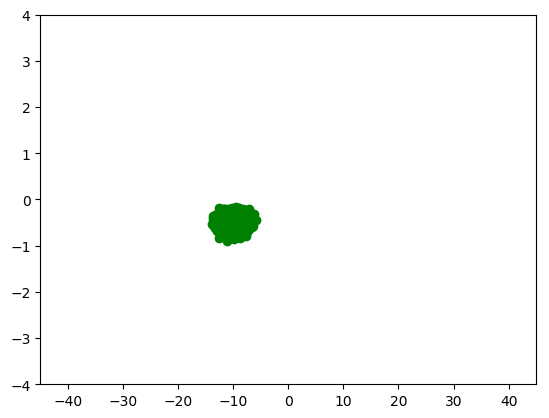

(-45, 45)

In [4]:
scatter(Xz0,Pz1,color="g")
ylim(-4,4)
xlim(-45,45)

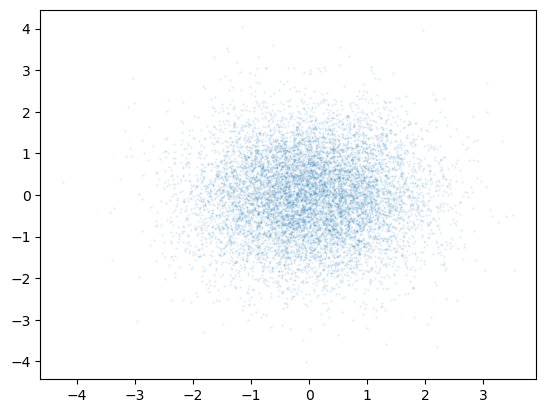

  0.177388 seconds (174.54 k allocations: 8.984 MiB)


PyObject <matplotlib.collections.PathCollection object at 0x14f35d590>

In [6]:
@time scatter(z0,z1,alpha=0.1,s=0.5)

In [5]:
initial_position = [0.1, 0.]
initial_momentum=[0. ,0.1]

2-element Array{Float64,1}:
 0.0
 0.1

In [21]:
function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
time=100.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.05
dts=0.001*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.

@time for jj =1:10000
    #println(jj)
    Hinicial=15.0
    initial_position[1]=grid[jj][1]
    initial_momentum[1]=grid[jj][2]
    
    initial_momentum[2]=energia_poinc_abs(initial_position[1],initial_momentum[1],m[1],m[2],a,b,Hinicial) #osciladores
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:10:end])
    push!(Q2,sol3[4,1:10:end])
    push!(P1,sol3[1,1:10:end])
    push!(P2,sol3[2,1:10:end])
    k=sol3
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%5==0
        PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.5)
        ylim(-6,6)
        xlim(-11,11)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%5==0
        PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.5)
        ylim(-2.5,2.5)
        xlim(-35,35)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)

BoundsError: BoundsError: attempt to access 70×70 Array{Array{Float64,1},2} at index [4901]

In [20]:
lim=1000
plot(entsys[1:400],label="system information")
plot(entpozo[1:400],label="particle information")
plot(entosci[1:400],label="oscillator information")
plot(entmutua[1:400],label="mutual information")
legend()
xlabel("time steps / 10")
ylabel("Shannon Information")
title("Mutual Information")
savefig("mutualinfo.png")
clf()

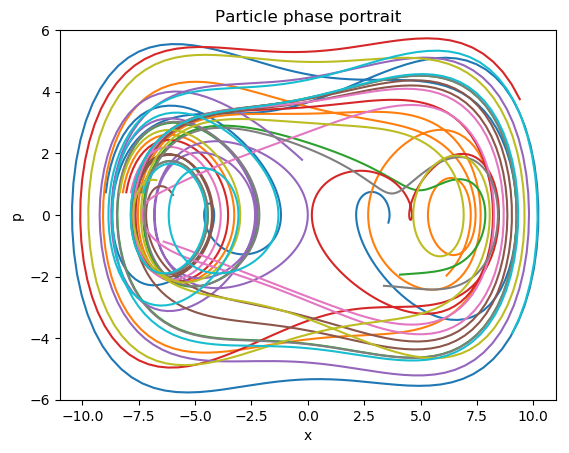

In [68]:
plot(Q1[1:400,1:10],P1[1:400,1:10])
title("Particle phase portrait")
xlabel("x")
ylabel("p")
ylim(-6,6)
xlim(-11,11)
savefig("mutualinfo_phase.png")
clf()

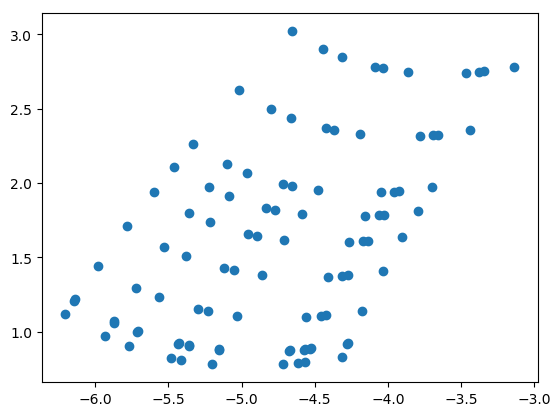

PyObject <matplotlib.collections.PathCollection object at 0x7f66095d7c50>

In [36]:
PyPlot.scatter(bbb[:,1],bbb[:,2])


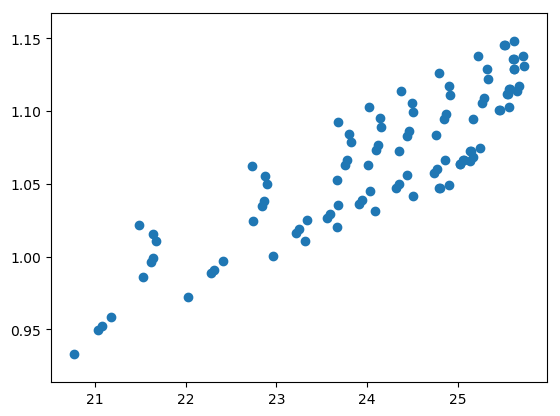

PyObject <matplotlib.collections.PathCollection object at 0x7f660805fe48>

In [62]:
PyPlot.scatter(ccc[:,1],ccc[:,2])

# Usando Box-Muller

In [ ]:
function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
time=100.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.05
dts=0.001*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.

@time for jj =1:arraysize
    if jj %100==0
        println(jj/arraysize)
    end
    #Hinicial=15.0
    initial_position[1]=xz0[jj]#0. #xz0[jj]
    initial_momentum[1]=pz1[jj]#0. #pz1[jj]
    initial_position[2]=Xz0[jj]
    initial_momentum[2]=Pz1[jj]
    
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:10:end])
    push!(Q2,sol3[4,1:10:end])
    push!(P1,sol3[1,1:10:end])
    push!(P2,sol3[2,1:10:end])
    k=sol3
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%5==0
        PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.2)
        ylim(-8,8)
        xlim(-14,14)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/boxmuller/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%5==0
        PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.2)
        ylim(-4,4)
        xlim(-45,45)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/boxmuller/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0
1448.447831 seconds (33.67 G allocations: 879.084 GiB, 11.34% gc time)
1126

In [ ]:
lim=arraysize
plot(entsys[1:end],label="system information")
plot(entpozo[1:end],label="particle information")
plot(entosci[1:end],label="oscillator information")
plot(entmutua[1:end],label="mutual information")
legend()
xlabel("time steps / 10")
ylabel("Shannon Information")
title("Mutual Information")
savefig("g0-05_division_mutualinfo_boxmuller.png")
clf()